In [15]:
from torchvision.datasets.mnist import MNIST
from torchvision.transforms import ToTensor, Compose, Normalize
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch
import numpy as np
import matplotlib.pyplot as plt

In [16]:
if torch.backends.cuda.is_built():
    device = torch.device('cuda')
elif torch.backends.mps.is_built():
    device = torch.device('mps')
else:
    device = torch.device('cpu')

print('Using device:', device)

Using device: cuda


In [17]:
mnist_train = MNIST('./data', download=True, transform=Compose([
                               ToTensor()]))

mnist_test = MNIST('./data', download=True, train=False, transform=Compose([
                               ToTensor()]))


mnist_train_loader = DataLoader(mnist_train, batch_size=64, shuffle=True)
mnist_test_loader = DataLoader(mnist_test, batch_size=64, shuffle=True)

# Exercise description

Objective of this exercise is to develop a variational autoencoder, plot reconstruction of input images is, visualize how the examples are distributed in the embedding space, and generated and plot new images.

The autoencoder will be based on a convolutional architecture with the same spec as the one used in the previous exercise.

## Encoder Layers:

- encoder1: Convolutional layer with 1 input channel, 16 output channels, a kernel size of 3, stride of 2, and padding of 1. Relu activation.
- encoder2: Convolutional layer with 16 input channels, 32 output channels, a kernel size of 3, stride of 2, and padding of 1. Relu activation.
- encoder3: Convolutional layer with 32 input channels, 64 output channels, a kernel size of 7, stride of 1, and no padding. Relu activation.
- mu: Fully connected (linear) layer reducing the dimensionality to z_size.
- sigma: Fully connected (linear) layer reducing the dimensionality to z_size.

## Decoder Layers:

- decoder1: Fully connected (linear) layer increasing the dimensionality from z_size to 64. Relu activation.
- decoder2: Transposed convolutional layer with 64 input channels, 32 output channels, a kernel size of 7, stride of 1, and no padding. Relu activation.
- decoder3: Transposed convolutional layer with 32 input channels, 16 output channels, a kernel size of 3, stride of 2, padding of 1, and output padding of 1. Relu activation.
- decoder4: Transposed convolutional layer with 16 input channels, 1 output channel, a kernel size of 3, stride of 2, padding of 1, and output padding of 1. Relu activation.

where z_size is a parameter of the model specifying the size of the embedding space.

In [18]:
class VAEModel(torch.nn.Module):
    def __init__(self, z_size=10):
        super(VAEModel, self).__init__()
        self.z_size = z_size
        # let's use a convolutional encoder/decoder pair

        self.encoder1 = torch.nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1)
        self.encoder2 = torch.nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1)
        self.encoder3 = torch.nn.Conv2d(32, 64, kernel_size=7, stride=1, padding=0)


        self.mu = torch.nn.Linear(64, z_size)
        self.sigma = torch.nn.Linear(64, z_size)

        self.decoder1 = torch.nn.Linear(z_size, 64)

        self.decoder2 = torch.nn.ConvTranspose2d(64, 32, kernel_size=7, stride=1, padding=0)
        self.decoder3 = torch.nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.decoder4 = torch.nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, padding=1, output_padding=1)


    # Reparameterization trick
    def reparameterize(self, mu, sigma):
        epsilon = torch.randn_like(mu)
        return mu + epsilon * sigma

    def encode(self, x):
        x = self.encoder1(x)
        x = F.relu(x)
        x = self.encoder2(x)
        x = F.relu(x)
        x = self.encoder3(x)
        x = F.relu(x)
        x = x.view(-1, 64)

        sigma = self.sigma(x)
        mu = self.mu(x)

        z = self.reparameterize(mu, sigma)
        return z, mu, sigma

    def decode(self, z):
        x = self.decoder1(z)
        x = F.relu(x)
        x = x.view(-1, 64, 1, 1)
        x = self.decoder2(x)
        x = F.relu(x)
        x = self.decoder3(x)
        x = F.relu(x)
        x = self.decoder4(x)
        x = torch.sigmoid(x)

        return x


    def forward(self, x):
        z, mu, sigma = self.encode(x)
        x = self.decode(z)

        return x, mu, sigma

    def generate(self):
        z = torch.randn(1, self.z_size).to(device)
        return self.decode(z)


In [19]:
def loss_fn(x, y):
    x_, mu, sigma = x

    # Reconstruction loss
    recon_loss =  F.mse_loss(x_, y, reduction="sum")

    # - KL Divergence loss
    kl_loss = 0.5 * torch.sum(sigma**2 + mu**2 -1 - torch.log(sigma**2))

    return recon_loss + kl_loss, recon_loss, kl_loss


In [20]:
model = VAEModel(10).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
tot_epochs = 0

In [21]:
epochs = 5

losses = []
for epoch in range(epochs):
    tot_epochs += 1
    train_loss = 0
    for i, (images, _) in enumerate(mnist_train_loader):
        images = images.to(device)
        outputs = model(images)
        loss, r_loss, kl_loss = loss_fn(outputs, images)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

        losses.append(loss.item())


    print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, epochs, train_loss / len(mnist_train_loader)))

print(f"Fionished training. Total epochs: {tot_epochs}")

Epoch [1/20], Loss: 3081.5489
Epoch [2/20], Loss: 2206.4205
Epoch [3/20], Loss: 2079.1519
Epoch [4/20], Loss: 2016.7956
Epoch [5/20], Loss: 1981.2976
Epoch [6/20], Loss: 1957.2859
Epoch [7/20], Loss: 1939.1169
Epoch [8/20], Loss: 1923.6294
Epoch [9/20], Loss: 1913.1788
Epoch [10/20], Loss: 1904.4130
Epoch [11/20], Loss: 1898.0303
Epoch [12/20], Loss: 1888.2378
Epoch [13/20], Loss: 1882.4701
Epoch [14/20], Loss: 1875.5703
Epoch [15/20], Loss: 1869.0684
Epoch [16/20], Loss: 1866.1410
Epoch [17/20], Loss: 1862.5673
Epoch [18/20], Loss: 1858.6469
Epoch [19/20], Loss: 1855.2872
Epoch [20/20], Loss: 1850.3912
Fionished training. Total epochs: 20


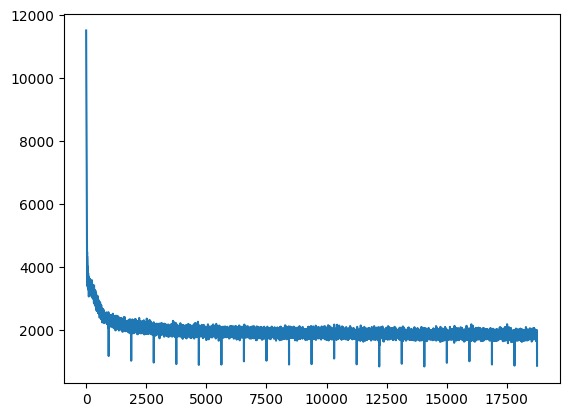

In [22]:
plt.plot(losses)

# Reconstruction

In [23]:
# torch.save(model.state_dict(), "vae_model.pth")
# model.load_state_dict(torch.load("vae_model.pth"))

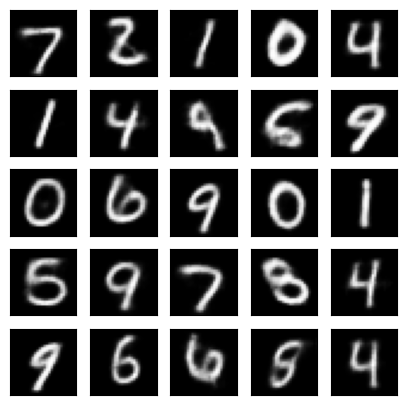

In [24]:
plt.figure(figsize=(5,5))
plt.gray()

imshape=(28,28)
preds = []

for i in range(25):
    with torch.no_grad():
        preds.append(model(mnist_test[i][0].to(device))[0].cpu().detach().float().numpy())

for i in range(25):
    ax = plt.subplot(5,5,i+1)
    # ax.imshow(preds[i].reshape(imshape))
    ax.imshow(preds[i].reshape(imshape), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

# Generation

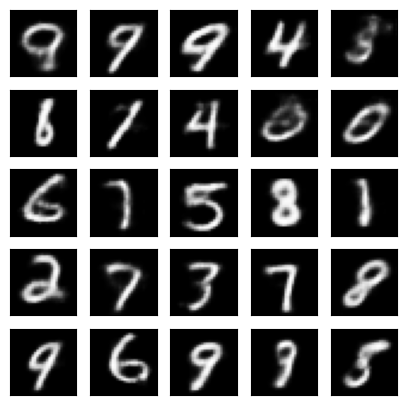

In [25]:
plt.figure(figsize=(5,5))
plt.gray()

imshape=(28,28)
preds = []

for i in range(25):
    with torch.no_grad():
        preds.append(model.generate().cpu().detach().float().numpy())
        # preds.append(model.generate().float().numpy())

for i in range(25):
    ax = plt.subplot(5,5,i+1)
    # ax.imshow(preds[i].reshape(imshape))
    ax.imshow(preds[i].reshape(imshape), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

# Interpolation (not in the exercise)

In [26]:
def plot_interpolations(img1, img2, nrows, ncols):
    """
    Generates a grid of interpolated images between two images from the MNIST dataset.

    Parameters:
        img1 (int): Index of the first image.
        img2 (int): Index of the second image.
        nrows (int): Number of rows of images in the grid.
        ncols (int): Number of columns of images in the grid.
    """
    img1 = mnist_train[img1][0]
    img2 = mnist_train[img2][0]

    _, mu1, _ = model.encode(img1.to(device))
    _, mu2, _ = model.encode(img2.to(device))

    preds = []

    num_steps = nrows * ncols

    for i in range(num_steps):
        z = mu1 + (mu2 - mu1) * (i / num_steps)
        with torch.no_grad():
            preds.append(model.decode(z).cpu().detach().float().numpy())

    for i in range(num_steps):
        ax = plt.subplot(nrows, ncols, i + 1)
        ax.imshow(preds[i].reshape(imshape), cmap="gray")
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show()

In [27]:
def plot_interpolations2(nrows, ncols):
    """
    Generates a grid of images interpolating between [-1, -1, 0] and [1, 1, 0] in the latent space.

    Parameters:
        nrows (int): Number of rows of images in the grid.
        ncols (int): Number of columns of images in the grid.
    """

    colstep = 2 / (ncols - 1)
    rowstep = 2 / (nrows - 1)

    for i in range(nrows):
        for j in range(ncols):
            z = torch.tensor([i * rowstep - 1, j * colstep - 1, 0.0]).to(device)
            img = model.decode(z).cpu().detach().float().numpy()
            ax = plt.subplot(nrows, ncols, i * ncols + j + 1)
            ax.imshow(img.reshape(imshape), cmap="gray")
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)

    plt.show()

In [28]:
plot_interpolations2(nrows=15, ncols=15)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x3 and 10x64)

# Latent space visualization

In [ ]:
import pandas as pd

def plot_latent_space(model, dataset_loader):
    """
    Plots the latent space of the VAE model.
    """
    z, labels = [], []
    for i, (batch, ys) in enumerate(dataset_loader):
        z_, _, _ = model.encode(batch.to(device))
        z.append(z_.cpu().detach().numpy())
        labels.append(ys.numpy())

        if i > 100:
            break

    z = np.concatenate(z, axis=0)
    labels = np.concatenate(labels, axis=0)

    z_embedded = z
    df = pd.DataFrame(np.concatenate([z_embedded, labels.reshape(-1,1)], axis=1), columns=["x", "y", "z", "label"])
    df["label"] = df["label"].astype(str)

    # scatter plot 3d using plotly
    import plotly.express as px
    fig = px.scatter_3d(df, x='x', y='y', z='z',
              color='label')
    fig.update_traces(marker_size = 3)

    fig.show()
    fig.write_html("plotly.html")


    # scatter plot 3d using plotly
    import plotly.express as px
    fig = px.scatter_3d(df, x='x', y='y', z='z',
              color='label', category_orders={"label": [str(i) for i in range(10)]})
    fig.update_traces(marker_size = 3)

    # fig.show()
    fig.write_html("vae-representations.html")




plot_latent_space(model, mnist_test_loader)